# Imports and dataset loading

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.multioutput import MultiOutputRegressor
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
import pandas as pd
from sklearn.base import clone
from sklearn.model_selection import train_test_split

strategyArray = []
gainArray     = []
lossArray     = []
ampNumber     = 3

originalDataSet = pd.read_csv('dataset.txt', sep = ',',header = None)
binaryDataSet   = []

for line in originalDataSet.values:
    myList = [1 if i != 0 else 0 for i in line[:40]]
    myList.extend(line[40:])
    binaryDataSet.append(myList)

binaryDataSet = pd.DataFrame(binaryDataSet)
gainScaler    = MinMaxScaler(feature_range = (-1, 1))
lossScaler    = MinMaxScaler(feature_range = (-1, 1))

gainScalerAux = []
lossScalerAux = []

for i in range(0, ampNumber * 2, 2):
    gainScalerAux.extend(binaryDataSet.values[:, 40 + i])
    lossScalerAux.extend(binaryDataSet.values[:, 40 + i + 1])

gainScaler.fit(np.array(gainScalerAux).reshape(-1, 1))
lossScaler.fit(np.array(lossScalerAux).reshape(-1, 1))

def loadDataset(): 
    dataSet = binaryDataSet.values[:, :40]
    
    for i in range(0, ampNumber * 2, 2):
        gain    = np.array(binaryDataSet.values[:, 40 + i])
        gain    = gainScaler.transform(gain.reshape(-1, 1))
        dataSet = np.hstack((dataSet, gain))
        
        loss    = np.array(binaryDataSet.values[:, 40 + i + 1])
        loss    = lossScaler.transform(loss.reshape(-1, 1))
        dataSet = np.hstack((dataSet, loss))
            
    features, result = np.array(dataSet[:, :40]), np.array(dataSet[:, 40:])
    
    return features, result

def invertGainNorm(value):
    auxArray = np.array([value, 0, 0, 0, 0, 0]).reshape(-1, 1)
    return gainScaler.inverse_transform(auxArray)[0][0]

def invertLossNorm(value):
    auxArray = np.array([value, 0, 0, 0, 0, 0]).reshape(-1, 1)
    return lossScaler.inverse_transform(auxArray)[0][0]
    
def getGainError(value1, value2):
    return abs(invertGainNorm(value1) - invertGainNorm(value2))

def getLossError(value1, value2):
    return abs(invertLossNorm(value1) - invertLossNorm(value2))

Using TensorFlow backend.


# Cross validation function

In [2]:
def crossValidate(regressor, features, result, folds = 5):
    foldSize   = math.ceil(features.shape[0] / folds)
    gainErrors = []
    lossErrors = []
    
    for i in range(folds): 
        sliceBegin = i * foldSize
        sliceEnd   = (i + 1) * foldSize
        
        X_train = np.delete(features, np.s_[sliceBegin: sliceEnd], 0)
        y_train = np.delete(result, np.s_[sliceBegin: sliceEnd], 0)
        
        if isinstance(regressor, Sequential):
            regressor.fit(X_train, y_train, epochs = 500, verbose = 0)  
        else:
            regressor.fit(X_train, y_train)
            
        X_test = features[sliceBegin: sliceEnd]
        y_test = result[sliceBegin: sliceEnd]
        
        gainError = 0
        lossError = 0
        
        prediction = regressor.predict(X_test)
        
        for predicted, expected in zip(prediction, y_test):
            gainError += getGainError(predicted[0], expected[0]) 
            lossError += getLossError(predicted[1], expected[1])
                 
        gainErrors.append((gainError / ampNumber) / foldSize)
        lossErrors.append((lossError / ampNumber) / foldSize) # average loss error by amp
        
    return np.array(gainErrors), np.array(lossErrors)

In [3]:
def trainModel(strategy):   
    features, result       = loadDataset()
    gainErrors, lossErrors = crossValidate(strategy, features, result[:, 0: 2])

    print(gainErrors, "=> %0.2f (+/- %0.2f)" % (np.mean(gainErrors), gainErrors.std() * 2))
    print(lossErrors, "=> %0.2f (+/- %0.2f)\n" % (np.mean(lossErrors), lossErrors.std() * 2))
    
    gainArray.append(gainErrors)
    lossArray.append(lossErrors)
    
    strategyArray.append("KNN - Amp 1")
    
    prediction1            = strategy.predict(features)
    strategy2              = clone(strategy)
    gainErrors, lossErrors = crossValidate(strategy2, np.hstack((features, prediction1)), result[:, 2: 4])

    print(gainErrors, "=> %0.2f (+/- %0.2f)" % (np.mean(gainErrors), gainErrors.std() * 2))
    print(lossErrors, "=> %0.2f (+/- %0.2f)\n" % (np.mean(lossErrors), lossErrors.std() * 2))
    
    gainArray.append(gainErrors)
    lossArray.append(lossErrors)
    strategyArray.append("KNN - Amp 2")
    
    prediction2            = strategy2.predict(np.hstack((features, prediction1)))
    strategy3              = clone(strategy)
    gainErrors, lossErrors = crossValidate(strategy3, np.hstack((features, prediction2)), result[:, 4: 6])

    print(gainErrors, "=> %0.2f (+/- %0.2f)" % (np.mean(gainErrors), gainErrors.std() * 2))
    print(lossErrors, "=> %0.2f (+/- %0.2f)\n" % (np.mean(lossErrors), lossErrors.std() * 2))
    
    gainArray.append(gainErrors)
    lossArray.append(lossErrors)
    strategyArray.append("KNN - Amp 3")
    
    return gainErrors, lossErrors

# Plotting functions

In [4]:
def plotDistribution(regressor):
    regressor2                       = clone(regressor)
    regressor3                       = clone(regressor)
    features, result                 = loadDataset()
    X_train, X_test, y_train, y_test = train_test_split(features, result, test_size = 0.3, random_state = 5)
    
    regressor.fit(X_train, y_train[:, 0: 2])
    train_result1 = regressor.predict(X_train)
    
    X_train2 = np.hstack((X_train, train_result1))
    regressor2.fit(X_train2, y_train[:, 2: 4])
    train_result2 = regressor2.predict(X_train2)
    
    X_train3 = np.hstack((X_train, train_result2))
    regressor3.fit(X_train3, y_train[:, 4: 6])
    train_result3 = regressor3.predict(X_train3)
        
    test_result1 = regressor.predict(X_test)
    test_result2 = regressor2.predict(np.hstack((X_test, test_result1)))
    test_result3 = regressor3.predict(np.hstack((X_test, test_result2)))
    
    fig, axis = plt.subplots(figsize = (10, 5))
    vGain     = np.vectorize(invertGainNorm)
    vLoss     = np.vectorize(invertLossNorm)
    
    axis.scatter(vGain(y_test[:, ampNumber * 2 - 2]), vLoss(y_test[:, ampNumber * 2 - 1]))
    axis.scatter(vGain(test_result3[:, 0]), vLoss(test_result3[:, 1]), c = "m")
    
    axis.set_title("Test Error - Last Amplifier")
    axis.set_xlabel("Gain")
    axis.set_ylabel("Loss")
    axis.legend(["expected", "predicted"])

    plt.show()

In [5]:
def plotGainError():
    fig, axis = plt.subplots(figsize = (10, 5))
    data      = gainArray

    axis.boxplot(data)
    axis.set_title("Train Gain Error", fontsize = 16)
    axis.set_xticklabels(np.repeat(strategyArray, 1))
    axis.set_ylabel("Absolute error (dB)", fontsize = 14)

    plt.show()

In [6]:
def plotLossError():
    fig, axis = plt.subplots(figsize = (10, 5))
    data      = lossArray

    axis.boxplot(data)
    axis.set_title("Train Loss Error", fontsize = 16)
    axis.set_xticklabels(np.repeat(strategyArray, 1))
    axis.set_ylabel("Absolute error (dB)", fontsize = 14)

    plt.show()

In [7]:
def plotLinkError():
    fig, axis = plt.subplots(figsize = (10, 5))
    lossData  = np.array(lossArray).flatten()
    gainData  = np.array(gainArray).flatten()
    
    axis.boxplot([lossData, gainData])
    axis.set_title("Link Train Error", fontsize = 16)
    axis.set_xticklabels(["Gain", "Error"])
    axis.set_ylabel("Absolute error (dB)", fontsize = 14)

    plt.show()

# Putting all together

In [8]:
gainArray = []
lossArray = []

In [9]:
knn = MultiOutputRegressor(KNeighborsRegressor())
trainModel(knn)

[0.8963884  0.82628774 0.92539964 0.47436353 0.8303138 ] => 0.79 (+/- 0.33)
[1.77075192 0.7079929  0.76009473 0.82936649 0.96933097] => 1.01 (+/- 0.78)

[0.90053286 0.38993487 0.02901125 0.92646536 1.25695678] => 0.70 (+/- 0.87)
[0.97975133 1.23291889 1.23161634 1.16897573 0.95701599] => 1.11 (+/- 0.24)

[0.37442274 0.31947898 0.34339846 0.3838958  0.3366489 ] => 0.35 (+/- 0.05)
[0.05494375 0.0812315  0.04026051 0.13179396 0.1589106 ] => 0.09 (+/- 0.09)



(array([0.37442274, 0.31947898, 0.34339846, 0.3838958 , 0.3366489 ]),
 array([0.05494375, 0.0812315 , 0.04026051, 0.13179396, 0.1589106 ]))

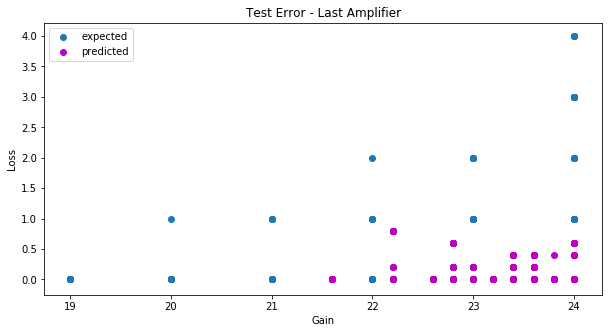

In [10]:
plotDistribution(knn)

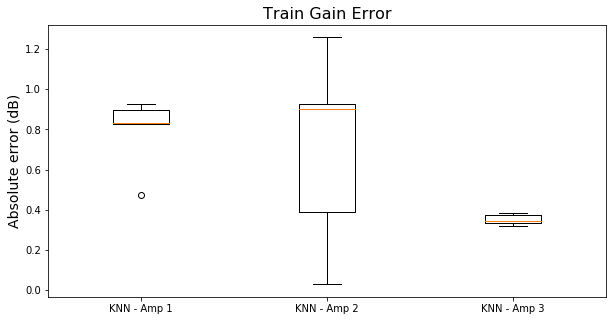

In [11]:
plotGainError()

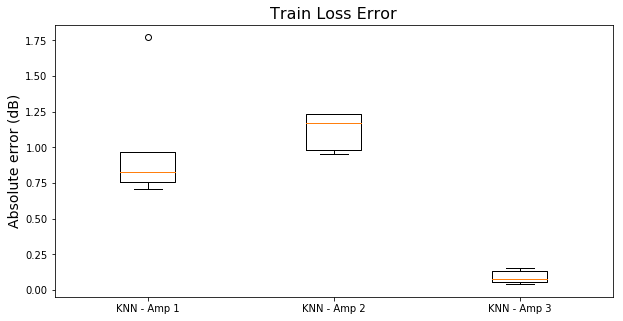

In [12]:
plotLossError()

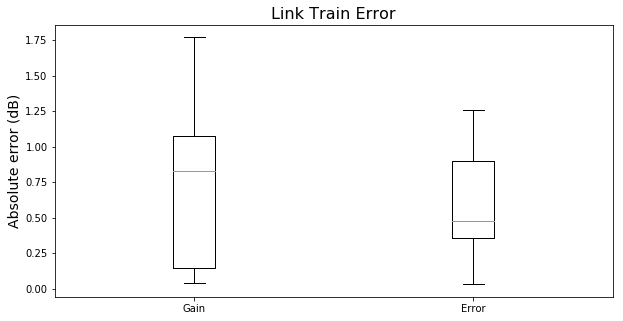

In [13]:
plotLinkError()